# Introduction to metabarcoding: DADA2 Tutorial

**Workshop led by: (Pedro E. Romero)** <br>
**Assisted by: Boris Vidal, Camila Castillo-Vilcahuaman** <br>
**Tutorial by: @reymonera (Camila Castillo-Vilcahuaman)**

This is a tutorial with all the necessary commands for the use of the R package DADA2. All the analysis are done and exposed here with their respective figures. In this opportunity, we will use data from an already published study: Metabarcoding in the most important river in Lima, Peru: The Rimac river.

This pipeline and tutorial is heavily based on another great bioinformatician's pipeline (Hi, @AstroBioMike!). If you want to learn more about this package, I highly suggest to visit this tutorial.

## 1. Getting to know the DADA2 package

First of all, we will get a first glance of how this environment stuff works. First of all, this is a Jupyter notebook. It is easier to show you guys how code works using these.
However, for our workshop to work well, we will need to set everything up first. So, for this, we will proceed with the following code:

```
conda env create -f dada2_env.yaml
conda activate dada2_env
python -m ipykernel install --user --name=dada2_env
jupyter-notebook
```

Now, we will proceed with enabling R code in this notebook. As you've probably guessed, Jupyer mainly runs with python. But we can make our own stuff run here using the following command:

In [1]:
%load_ext rpy2.ipython

/home/marlen/miniforge3/envs/dada2_env/lib/python3.12/site-packages/rpy2/ipython/rmagic.py:85: UserWarning: The Python package `pandas` is strongly recommended when using `rpy2.ipython`. Unfortunately it could not be loaded, as we did not manage to load `numpy` in the first place (error: No module named 'numpy').
  warnings.warn('The Python package `pandas` is strongly '


## 2. Getting to know our data

We start by downloading the necessary information for our analysis. We will be working with data from the study of microbial communities present in an environmental sediment. To do this, we need to download it as follows:  

In [2]:
!cd ~
!curl -L -o dada2_amplicon_ex_workflow.tar.gz https://ndownloader.figshare.com/files/28773936
!tar -xzvf dada2_amplicon_ex_workflow.tar.gz
!rm dada2_amplicon_ex_workflow.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  102M  100  102M    0     0  4644k      0  0:00:22  0:00:22 --:--:-- 7208k
dada2_amplicon_ex_workflow/
dada2_amplicon_ex_workflow/R8_sub_R2.fq
dada2_amplicon_ex_workflow/sample_info.tsv
dada2_amplicon_ex_workflow/R12_sub_R1.fq
dada2_amplicon_ex_workflow/R5_sub_R2.fq
dada2_amplicon_ex_workflow/B3_sub_R1.fq
dada2_amplicon_ex_workflow/R6_sub_R1.fq
dada2_amplicon_ex_workflow/R11_sub_R2.fq
dada2_amplicon_ex_workflow/R3_sub_R2.fq
dada2_amplicon_ex_workflow/R1B_sub_R1.fq
dada2_amplicon_ex_workflow/R9_sub_R2.fq
dada2_amplicon_ex_workflow/B1_sub_R2.fq
dada2_amplicon_ex_workflow/B4_sub_R1.fq
dada2_amplicon_ex_workflow/amplicon_dada2_ex.RData
dada2_amplicon_ex_workflow/R11BF_sub_R1.fq
dada2_amplicon_ex_workflow/tax-info.RData
dada2_amplicon_ex_workflow/BW1_sub

<div style="background-color: #fff8b3; padding: 10px; border-radius: 5px;">
    <strong>Important:</strong> We will be working with 2 datasets. The first one is the one featured above, but for the second excercise, we will be working with a local repository containing data from the work done in the Rimac river. Instructions on how to handle this data will be indicated below.
</div>

With the last command, we can navigate inside the folder. If we run `ls`, we will see the new files we have acquired.

- Now, we will need a list of the files named `samples` containing the names of each file. This will simplify navigating through the files and facilitate various aspects of processing. We will be referencing these files constantly. Staying in the "Terminal," execute the following command:

In [3]:
!ls dada2_amplicon_ex_workflow
!mv dada2_amplicon_ex_workflow/* .

B1_sub_R1.fq   R10_sub_R1.fq	R2_sub_R1.fq  R8_sub_R1.fq
B1_sub_R2.fq   R10_sub_R2.fq	R2_sub_R2.fq  R8_sub_R2.fq
B2_sub_R1.fq   R11BF_sub_R1.fq	R3_sub_R1.fq  R9_sub_R1.fq
B2_sub_R2.fq   R11BF_sub_R2.fq	R3_sub_R2.fq  R9_sub_R2.fq
B3_sub_R1.fq   R11_sub_R1.fq	R4_sub_R1.fq  all_R_commands.R
B3_sub_R2.fq   R11_sub_R2.fq	R4_sub_R2.fq  amplicon_dada2_ex.RData
B4_sub_R1.fq   R12_sub_R1.fq	R5_sub_R1.fq  primers.fa
B4_sub_R2.fq   R12_sub_R2.fq	R5_sub_R2.fq  sample_info.tsv
BW1_sub_R1.fq  R1A_sub_R1.fq	R6_sub_R1.fq  tax-info.RData
BW1_sub_R2.fq  R1A_sub_R2.fq	R6_sub_R2.fq
BW2_sub_R1.fq  R1B_sub_R1.fq	R7_sub_R1.fq
BW2_sub_R2.fq  R1B_sub_R2.fq	R7_sub_R2.fq


In [4]:
!ls *_R1.fq | cut -f1 -d "_" > samples

- It’s time to process our read files. This involves trimming the default adapters they come with. We can achieve this using `cutadapt`. In our terminal, execute the following command:

<div style="background-color: #fff8b3; padding: 10px; border-radius: 5px;">
    <strong>Important:</strong> This is only running for one sample as an example of how cutadapt works.
</div>

In [5]:
!cutadapt --version # 2.3
!cutadapt -a ^GTGCCAGCMGCCGCGGTAA...ATTAGAWACCCBDGTAGTCC \
-A ^GGACTACHVGGGTWTCTAAT...TTACCGCGGCKGCTGGCAC \
-m 215 -M 285 --discard-untrimmed \
-o B1_sub_R1_trimmed.fq -p B1_sub_R2_trimmed.fq \
B1_sub_R1.fq B1_sub_R2.fq

4.9
This is cutadapt 4.9 with Python 3.12.7
Command line parameters: -a ^GTGCCAGCMGCCGCGGTAA...ATTAGAWACCCBDGTAGTCC -A ^GGACTACHVGGGTWTCTAAT...TTACCGCGGCKGCTGGCAC -m 215 -M 285 --discard-untrimmed -o B1_sub_R1_trimmed.fq -p B1_sub_R2_trimmed.fq B1_sub_R1.fq B1_sub_R2.fq
Processing paired-end reads on 1 core ...
Done           00:00:00         1,671 reads @  20.4 µs/read;   2.95 M reads/minute
Finished in 0.035 s (21.090 µs/read; 2.84 M reads/minute).

=== Summary ===

Total read pairs processed:              1,671
  Read 1 with adapter:                   1,664 (99.6%)
  Read 2 with adapter:                   1,619 (96.9%)

== Read fate breakdown ==
Pairs that were too short:                   4 (0.2%)
Pairs that were too long:                   46 (2.8%)
Pairs written (passing filters):         1,612 (96.5%)

Total basepairs processed:       987,870 bp
  Read 1:       486,896 bp
  Read 2:       500,974 bp
Total written (filtered):        819,853 bp (83.0%)
  Read 1:       408,085 bp
  

Y ejecutaremos `cutadapt` para B1. Si deseamos ejecutar cutadapt para el resto de nuestras
muestras, lo mejor será utilizar un artilugio del lenguaje Bash:

In [6]:
%%bash
for sample in $(cat samples)
do

    echo "On sample: $sample"
    
    cutadapt -a ^GTGCCAGCMGCCGCGGTAA...ATTAGAWACCCBDGTAGTCC \
             -A ^GGACTACHVGGGTWTCTAAT...TTACCGCGGCKGCTGGCAC \
             -m 215 -M 285 --discard-untrimmed \
             -o ${sample}_sub_R1_trimmed.fq.gz -p ${sample}_sub_R2_trimmed.fq.gz \
             ${sample}_sub_R1.fq ${sample}_sub_R2.fq \
             >> cutadapt_primer_trimming_stats.txt 2>&1

done

On sample: B1
On sample: B2
On sample: B3
On sample: B4
On sample: BW1
On sample: BW2
On sample: R10
On sample: R11BF
On sample: R11
On sample: R12
On sample: R1A
On sample: R1B
On sample: R2
On sample: R3
On sample: R4
On sample: R5
On sample: R6
On sample: R7
On sample: R8
On sample: R9


Esto terminará por realizar el tratamiento en nuestra data. Ahora sí, podremos dirigirnos a la consola de R y empezar a poner todo en orden. Primero, señalamos en donde nos vamos a quedar y cuál será nuestro espacio de trabajo:

## 3. Starting with DADA2

In [7]:
%%R
getwd()

[1] "/home/marlen/gitrepos/dada2_msm-course-2024"


<div style="background-color: #fff8b3; padding: 10px; border-radius: 5px;">
    <strong>Important:</strong> It is important to check from where is dada2 calling the required libraries. If it is not correctly directed, you should do it manually with the following cell:
</div>

In [8]:
%%R
.libPaths("/home/marlen/miniforge-pypy3/envs/dada2_env/lib/R/library")
.libPaths()

[1] "/home/marlen/miniforge3/envs/dada2_env/lib/R/library"


In [9]:
%%R
library(dada2)
packageVersion("dada2")

[1] ‘1.30.0’


Loading required package: Rcpp


Crea una variable llamada `samples`

In [10]:
%%R
samples <- scan("samples", what="character")
list.files()

 [1] "all_R_commands.R"                             
 [2] "amplicon_dada2_ex.RData"                      
 [3] "B1_sub_R1_trimmed.fq"                         
 [4] "B1_sub_R1_trimmed.fq.gz"                      
 [5] "B1_sub_R1.fq"                                 
 [6] "B1_sub_R2_trimmed.fq"                         
 [7] "B1_sub_R2_trimmed.fq.gz"                      
 [8] "B1_sub_R2.fq"                                 
 [9] "B2_sub_R1_trimmed.fq.gz"                      
[10] "B2_sub_R1.fq"                                 
[11] "B2_sub_R2_trimmed.fq.gz"                      
[12] "B2_sub_R2.fq"                                 
[13] "B3_sub_R1_trimmed.fq.gz"                      
[14] "B3_sub_R1.fq"                                 
[15] "B3_sub_R2_trimmed.fq.gz"                      
[16] "B3_sub_R2.fq"                                 
[17] "B4_sub_R1_trimmed.fq.gz"                      
[18] "B4_sub_R1.fq"                                 
[19] "B4_sub_R2_trimmed.fq.gz"                

Read 20 items


Crea dos variables para los archivos filtrados

In [11]:
%%R

# We will create the variables for hosting the filtered reads

filtered_forward_reads <- paste0(samples, "_sub_R1_filtered.fq.gz")
filtered_reverse_reads <- paste0(samples, "_sub_R2_filtered.fq.gz")

Crea dos variables `lecturas_directas(forward_reads)` y `lecturas_reversas(reverse_reads)` añadiendo etiquetas _R1 o _R2 a la variable muestras, de modo que concuerde con los nombres de archivo

In [12]:
%%R

forward_reads <- paste0(samples, "_sub_R1_trimmed.fq.gz")
reverse_reads <- paste0(samples, "_sub_R2_trimmed.fq.gz")

#Iremos creando las variables en donde entrarán los reads ya “podados”
trimmed_forward_reads <- paste0(samples, "_1_trimmed.fastq")
trimmed_reverse_reads <- paste0(samples, "_2_trimmed.fastq")

#Just for the River samples with blanks:
#A matrix with no blanks was included so that we could get a matrix of reads without the used blanks.
#trimmed_forward_reads[1:20] -> trimmed_forward_reads_noblanks
#trimmed_reverse_reads[1:20] -> trimmed_reverse_reads_noblanks

### Quality Plots 

Para saber en donde vamos a cortar, necesitaremos primero ver gráficos de calidad. Eso lo lograremos mediante el comando que le solicita a DADA2 un perfil de calidad, mediante los siguientes comandos:

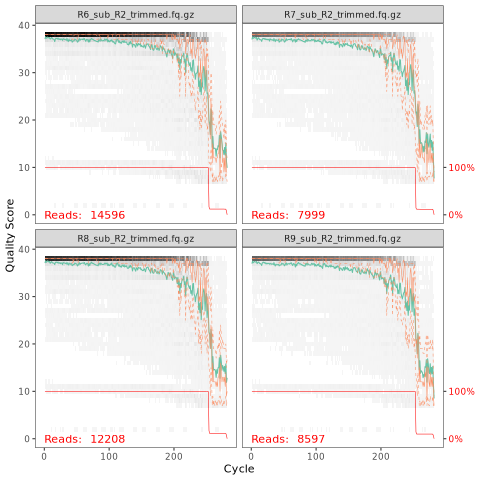

In [13]:
%%R

# Plotted using the following commands:

#plotQualityProfile(forward_reads)
#plotQualityProfile(reverse_reads)

# Since that's too messy, we can plot only 4 samples to make it easier. Like this:
plotQualityProfile(reverse_reads[17:20])

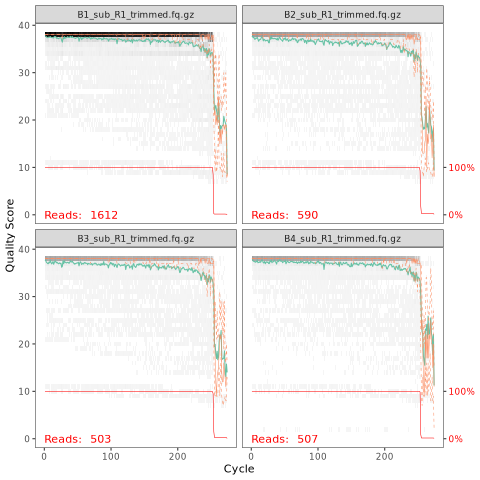

In [14]:
%%R

# Or this:
plotQualityProfile(forward_reads[1:4])

If we check our quality plots, the length of these lectures is of 250 nt. At which point it is that we can detect a quality fall? This information can help us with the information we need to add in our parameters.

Then, we will use the `filterAndTrim` command, which can allow us to edit the reads according to our needs:

In [15]:
%%R

filtered_out <- filterAndTrim(forward_reads, filtered_forward_reads,
                reverse_reads, filtered_reverse_reads, maxEE=c(2,2),
                rm.phix=TRUE, minLen=175, truncLen=c(250,200))

filtered_out

#Podemos explorar nuestra data con:
class(filtered_out)
dim(filtered_out)

[1] 20  2


In [16]:
%%R

filtered_out

                           reads.in reads.out
B1_sub_R1_trimmed.fq.gz        1612      1497
B2_sub_R1_trimmed.fq.gz         590       528
B3_sub_R1_trimmed.fq.gz         503       457
B4_sub_R1_trimmed.fq.gz         507       475
BW1_sub_R1_trimmed.fq.gz       2294      2109
BW2_sub_R1_trimmed.fq.gz       6015      5525
R10_sub_R1_trimmed.fq.gz      11250     10346
R11BF_sub_R1_trimmed.fq.gz     8622      8024
R11_sub_R1_trimmed.fq.gz       8923      8134
R12_sub_R1_trimmed.fq.gz      15660     14403
R1A_sub_R1_trimmed.fq.gz      12103     10901
R1B_sub_R1_trimmed.fq.gz      16084     14666
R2_sub_R1_trimmed.fq.gz       17191     15655
R3_sub_R1_trimmed.fq.gz       17489     15945
R4_sub_R1_trimmed.fq.gz       18962     17319
R5_sub_R1_trimmed.fq.gz       18197     16716
R6_sub_R1_trimmed.fq.gz       14596     13334
R7_sub_R1_trimmed.fq.gz        7999      7327
R8_sub_R1_trimmed.fq.gz       12208     11189
R9_sub_R1_trimmed.fq.gz        8597      7850


It's worth checking now if our filter was really worthwhile or not. To do this, we can redraw the data we have available:

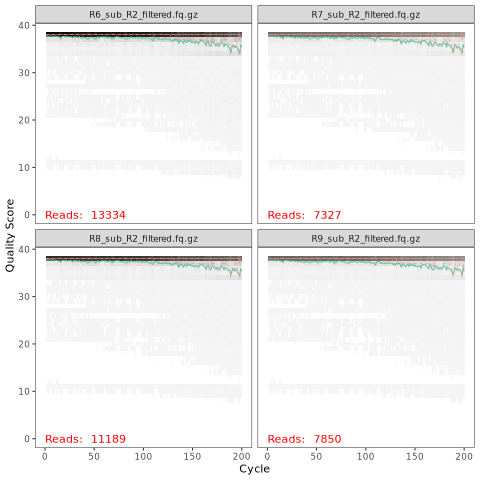

In [17]:
%%R

plotQualityProfile(filtered_reverse_reads[17:20])

Did the trimming and filtering have any effect?

### Learning from our errors

No sequencing is free of errors, and DADA2 wants to identify them. This step is only necessary for our package. The information we are interested in here is minimal, but it is still an important (and computationally intensive) step:

In [18]:
%%R

err_forward_reads <- learnErrors(filtered_forward_reads, multithread=TRUE)
err_reverse_reads <- learnErrors(filtered_reverse_reads, multithread=TRUE)

45600000 total bases in 182400 reads from 20 samples will be used for learning the error rates.
36480000 total bases in 182400 reads from 20 samples will be used for learning the error rates.


Finally, we proceed to plot our error graphs as follows:

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In scale_y_log10() :
R[write to console]:  log-10 transformation introduced infinite values.

R[write to console]: 2: 
R[write to console]: In scale_y_log10() :
R[write to console]:  log-10 transformation introduced infinite values.



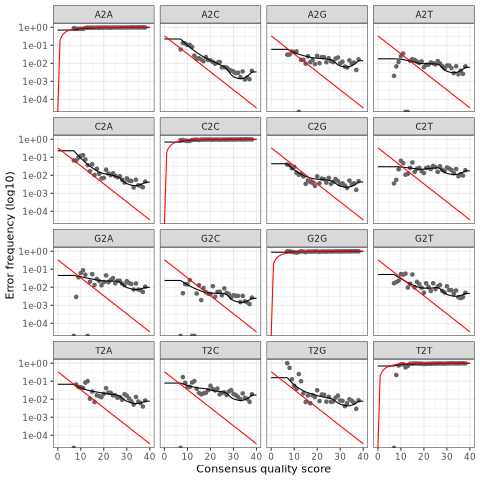

In [19]:
%%R

plotErrors(err_forward_reads, nominalQ=TRUE)

And we obtain... this:

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In scale_y_log10() :
R[write to console]:  log-10 transformation introduced infinite values.

R[write to console]: 2: 
R[write to console]: In scale_y_log10() :
R[write to console]:  log-10 transformation introduced infinite values.



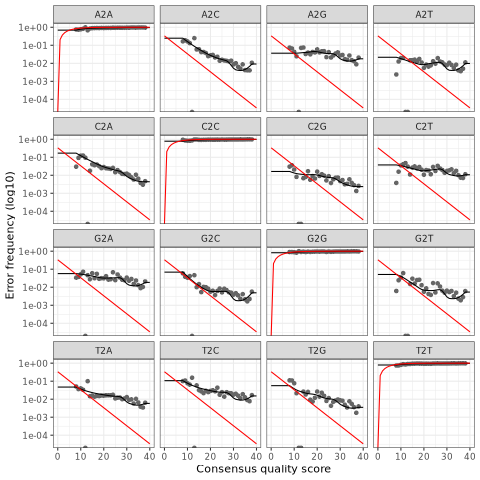

In [20]:
%%R

plotErrors(err_reverse_reads, nominalQ=TRUE)

Ahm... there's not much to do here. Once again, learning the errors is something that will be needed in later commands. In our case, the only important thing is that the black dots follow the black curve. This indicates the association between observed and estimated values.

### Derreplication

Do we want to spend our resources trying to identify trillions of identical sequences?

Wouldn't it be better to specify the sequence and indicate how many times it appears?

Okay, then we will use the command that allows us to do this:

In [21]:
%%R

derep_forward <- derepFastq(filtered_forward_reads, verbose=TRUE)
names(derep_forward) <- samples

derep_reverse <- derepFastq(filtered_reverse_reads, verbose=TRUE)
names(derep_reverse) <- samples

Dereplicating sequence entries in Fastq file: B1_sub_R1_filtered.fq.gz
Encountered 551 unique sequences from 1497 total sequences read.
Dereplicating sequence entries in Fastq file: B2_sub_R1_filtered.fq.gz
Encountered 224 unique sequences from 528 total sequences read.
Dereplicating sequence entries in Fastq file: B3_sub_R1_filtered.fq.gz
Encountered 186 unique sequences from 457 total sequences read.
Dereplicating sequence entries in Fastq file: B4_sub_R1_filtered.fq.gz
Encountered 203 unique sequences from 475 total sequences read.
Dereplicating sequence entries in Fastq file: BW1_sub_R1_filtered.fq.gz
Encountered 723 unique sequences from 2109 total sequences read.
Dereplicating sequence entries in Fastq file: BW2_sub_R1_filtered.fq.gz
Encountered 2758 unique sequences from 5525 total sequences read.
Dereplicating sequence entries in Fastq file: R10_sub_R1_filtered.fq.gz
Encountered 5498 unique sequences from 10346 total sequences read.
Dereplicating sequence entries in Fastq file:

### Inferring ASVs with the DADA algorithm

Now, let's move on to the ASVs. We've talked a lot about them, but it was about time to use a command to display them on our screens. Here's how we use the following:

In [22]:
%%R

dada_forward <- dada(derep_forward, err=err_forward_reads, pool="pseudo", multithread=T)
dada_reverse <- dada(derep_reverse, err=err_reverse_reads, pool="pseudo", multithread=T)

Sample 1 - 1497 reads in 551 unique sequences.
Sample 2 - 528 reads in 224 unique sequences.
Sample 3 - 457 reads in 186 unique sequences.
Sample 4 - 475 reads in 203 unique sequences.
Sample 5 - 2109 reads in 723 unique sequences.
Sample 6 - 5525 reads in 2758 unique sequences.
Sample 7 - 10346 reads in 5498 unique sequences.
Sample 8 - 8024 reads in 3449 unique sequences.
Sample 9 - 8134 reads in 4843 unique sequences.
Sample 10 - 14403 reads in 9736 unique sequences.
Sample 11 - 10901 reads in 6890 unique sequences.
Sample 12 - 14666 reads in 9376 unique sequences.
Sample 13 - 15655 reads in 9304 unique sequences.
Sample 14 - 15945 reads in 10221 unique sequences.
Sample 15 - 17319 reads in 10402 unique sequences.
Sample 16 - 16716 reads in 10974 unique sequences.
Sample 17 - 13334 reads in 8516 unique sequences.
Sample 18 - 7327 reads in 4427 unique sequences.
Sample 19 - 11189 reads in 6169 unique sequences.
Sample 20 - 7850 reads in 4234 unique sequences.

   selfConsist step 2Sa

The last parameter, `pool`, is difficult to explain, but we can say that the two options were either to check sample by sample or to combine all the samples in what is known as "pooling." However, this could end up ignoring some sequences that would be lost in the "pool" of options.

Thus, *pseudo-pooling* was created. Next, we will merge the forward and reverse sequences, as this will be our target sequence for identification. We will achieve this with the following commands:

In [23]:
%%R

merged_amplicons <- mergePairs(dada_forward, derep_forward, dada_reverse, derep_reverse, trimOverhang=TRUE, minOverlap=170)

We can explore this variable a bit using the following commands:

In [24]:
%%R

class(merged_amplicons)

[1] "list"


In [25]:
%%R
length(merged_amplicons)

[1] 20


In [26]:
%%R
names(merged_amplicons)

 [1] "B1"    "B2"    "B3"    "B4"    "BW1"   "BW2"   "R10"   "R11BF" "R11"  
[10] "R12"   "R1A"   "R1B"   "R2"    "R3"    "R4"    "R5"    "R6"    "R7"   
[19] "R8"    "R9"   


In [27]:
%%R
class(merged_amplicons$B1)

[1] "data.frame"


In [28]:
%%R
names(merged_amplicons$B1)

[1] "sequence"  "abundance" "forward"   "reverse"   "nmatch"    "nmismatch"
[7] "nindel"    "prefer"    "accept"   


### ASVs count table

Perhaps the most important output is the table that is obtained, commonly known as the counts table. We can produce it as follows:

In [29]:
%%R

seqtab <- makeSequenceTable(merged_amplicons)

class(seqtab) # matrix
dim(seqtab) # 20 2521

[1]   20 2521


### Chimera identification

Finally, we will identify the chimeras. These are sequences that are joined together without any specific biological meaning. DADA2 performs this identification by making estimations between the most abundant and the least abundant sequences, trying to infer if they could have been joined in some way.

In [30]:
%%R

seqtab.nochim <- removeBimeraDenovo(seqtab, verbose=T)

#Y podemos revisar cuánto hemos perdido con esto también. La idea es que tengamos un decimal cercano al 1:
sum(seqtab.nochim)/sum(seqtab)

[1] 0.993133


Identified 17 bimeras out of 2521 input sequences.


Finally, to complete this step, it is useful to have a summary table of everything we have done:

In [31]:
%%R

getN <- function(x) sum(getUniques(x))
summary_tab <- data.frame(row.names=samples,
dada2_input=filtered_out[,1], filtered=filtered_out[,2],
dada_f=sapply(dada_forward, getN), dada_r=sapply(dada_reverse, getN),
merged=sapply(merged_amplicons, getN), nonchim=rowSums(seqtab.nochim),
final_perc_reads_retained=round(rowSums(seqtab.nochim)/filtered_out[,1]
*100, 1))

summary_tab

write.table(summary_tab, "read-count-tracking.tsv", quote=FALSE, sep="\t", col.names=NA)

## 4. Assigning taxonomy

Normally, to complete this step, we would need to download the 16S rRNA database [SILVA] (https://zenodo.org/record/3731176#.YJa8K-hKg2w). However, our capabilities are somewhat limited in this regard. The best I can do is provide a code, which is better not to execute:

In [32]:
#%%R
## skipping this codeblock for time, and it will not run in the binder environment
## downloading DECIPHER-formatted SILVA v138 reference
#download.file(url="http://www2.decipher.codes/Classification/TrainingSets/SILVA_SSU_r138_2019.RData", destfile="SILVA_SSU_r138_2019.RData")

## loading reference taxonomy object
# load("SILVA_SSU_r138_2019.RData")
## loading DECIPHER
# library(DECIPHER)
# packageVersion("DECIPHER") # v2.6.0 when this was initially put together, though might be different in the binder or conda installation, that's ok!

## creating DNAStringSet object of our ASVs
# dna <- DNAStringSet(getSequences(seqtab.nochim))
## and classifying
# tax_info <- IdTaxa(test=dna, trainingSet=trainingSet, strand="both", processors=NULL)

Since we don't have these capabilities, we will use the following, which is data already estimated by the author and allows us to access this analysis right away:

In [33]:
%%R
load("tax-info.RData")

### Taxa-information tables

Normally, in this type of study, we require tables of sequences, counts, and taxonomy. These are standard formats that can be exported to other packages. We can achieve this with the following commands:

In [34]:
%%R

# asignando nuevos nombres (ASV_1, ASV_2...)
asv_seqs <- colnames(seqtab.nochim)
asv_headers <- vector(dim(seqtab.nochim)[2], mode="character")

for (i in 1:dim(seqtab.nochim)[2]) {
asv_headers[i] <- paste(">ASV", i, sep="_")
}

# escribiendo fastas de nuestros ASVs
asv_fasta <- c(rbind(asv_headers, asv_seqs))
write(asv_fasta, "ASVs.fa")

# Tabla de conteo:
asv_tab <- t(seqtab.nochim)
row.names(asv_tab) <- sub(">", "", asv_headers)
write.table(asv_tab, "ASVs_counts.tsv", sep="\t", quote=F, col.names=NA)

# Tabla de taxas:
# Crear tabla de taxonomías y diciendo que los que no existen son NA
ranks <- c("domain", "phylum", "class", "order", "family", "genus", "species")

asv_tax <- t(sapply(tax_info, function(x) {
    m <- match(ranks, x$rank)
    taxa <- x$taxon[m]
    taxa[startsWith(taxa, "unclassified_")] <- NA
    taxa
}))

colnames(asv_tax) <- ranks
rownames(asv_tax) <- gsub(pattern=">", replacement="", x=asv_headers)

write.table(asv_tax, "ASVs_taxonomy.tsv", sep = "\t", quote=F, col.names=NA)

### Identifying contaminants

Something very important in this type of study is having blanks. Samples with nothing in them that can tell us if there are contaminants in our own samples. In this way, if species 1 is found in the blank, it becomes easier to remove species 1 from the samples. We can perform this discard using the following package:

In [35]:
%%R

library(decontam)
packageVersion("decontam")

colnames(asv_tab) # en estas muestras, los blancos son los primeros 4

vector_for_decontam <- c(rep(TRUE, 4), rep(FALSE, 16))
contam_df <- isContaminant(t(asv_tab), neg=vector_for_decontam)
table(contam_df$contaminant)

contam_asvs <- row.names(contam_df[contam_df$contaminant == TRUE, ])

Aha, identified. Now, let's remove them and perform counts without contaminants:

In [36]:
%%R

# haciendo un nuevo archivo fasta
contam_indices <- which(asv_fasta %in% paste0(">", contam_asvs))
dont_want <- sort(c(contam_indices, contam_indices + 1))
asv_fasta_no_contam <- asv_fasta[- dont_want]

# haciendo una nueva tabla de conteos
asv_tab_no_contam <- asv_tab[!row.names(asv_tab) %in% contam_asvs, ]

# realizando una nueva tabla de taxonomía
asv_tax_no_contam <- asv_tax[!row.names(asv_tax) %in% contam_asvs, ]

In [37]:
%%R

## y ahora escribiéndolo a nuevos archivos
write(asv_fasta_no_contam, "ASVs-no-contam.fa")

write.table(asv_tab_no_contam, "ASVs_counts-no-contam.tsv", sep="\t", quote=F, col.names=NA)
write.table(asv_tax_no_contam, "ASVs_taxonomy-no-contam.tsv", sep="\t", quote=F, col.names=NA)

## 5. Calculating Diversity

#### Setup

In [38]:
%%R

library(tidyverse)
library(phyloseq)
library(vegan)
library(DESeq2)
library(dendextend)
library(viridis)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-8
Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Attaching package: ‘S4Vectors’

The fol

These are the necessary libraries. Now, let's prepare our tables.

In [39]:
%%R

write(asv_fasta_no_contam, "ASVs-no-contam.fa")
write.table(asv_tab_no_contam, "ASVs_counts-no-contam.tsv", sep="\t", quote=F, col.names=NA)
write.table(asv_tax_no_contam, "ASVs_taxonomy-no-contam.tsv", sep="\t", quote=F, col.names=NA)

#ATENCION: Esto remueve todos tus archivos. Asegúrate de que tienes todo.

rm(list=ls())
count_tab <- read.table("ASVs_counts-no-contam.tsv", header=T, row.names=1, check.names=F, sep="\t")[ , -c(1:4)]

Now we should import our metadata table. Very important when it comes to the community analysis we will perform onwards:

In [40]:
%%R

tax_tab <- as.matrix(read.table("ASVs_taxonomy-no-contam.tsv", header=T, row.names=1, check.names=F, sep="\t"))
sample_info_tab <- read.table("sample_info.tsv", header=T, row.names=1, check.names=F, sep="\t")

#Vamos a necesitar esta columna pronto

# Only for the example data:
sample_info_tab$color <- as.character(sample_info_tab$color)
sample_info_tab # checa

      temp    type      char      color
BW1    2.0   water     water       blue
BW2    2.0   water     water       blue
R10   13.7    rock    glassy      black
R11BF  7.3 biofilm   biofilm  darkgreen
R11    7.3    rock    glassy      black
R12     NA    rock   altered chocolate4
R1A    8.6    rock   altered chocolate4
R1B    8.6    rock   altered chocolate4
R2     8.6    rock   altered chocolate4
R3    12.7    rock   altered chocolate4
R4    12.7    rock   altered chocolate4
R5    12.7    rock   altered chocolate4
R6    12.7    rock   altered chocolate4
R7      NA    rock carbonate  darkkhaki
R8    13.5    rock    glassy      black
R9    13.7    rock    glassy      black


Now, with this, we need to normalize our data. There are several techniques for this. We will use a package that can perform this function for us without the need to resort to mysterious techniques:

In [41]:
%%R

deseq_counts <- DESeqDataSetFromMatrix(count_tab, colData = sample_info_tab, design = ~type)
deseq_counts_vst <- varianceStabilizingTransformation(deseq_counts)

# ATENCIÓN por si figura un error:
# deseq_counts <- estimateSizeFactors(deseq_counts, type = "poscounts")
# deseq_counts_vst <- varianceStabilizingTransformation(deseq_counts)

vst_trans_count_tab <- assay(deseq_counts_vst)
euc_dist <- dist(t(vst_trans_count_tab))
#Esto permite calcular la distancia euclidiana que requerimos para nuestra primera evaluación de beta-diversidad

In addition: Warning message:
In DESeqDataSet(se, design = design, ignoreRank) :
  some variables in design formula are characters, converting to factors


### Beta-diversity

Now that the distances are calculated, we are ready to plot our first graph, which would be the following:

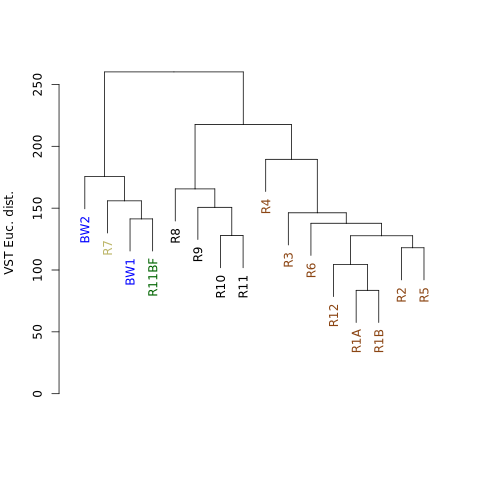

In [42]:
%%R

euc_clust <- hclust(euc_dist, method="ward.D2")

#Se puede plotear de este modo
plot(euc_clust)

#Como también podemos transformarlo en un dendograma, que es más simple de editar
euc_dend <- as.dendrogram(euc_clust, hang=0.1)
dend_cols <- as.character(sample_info_tab$color[order.dendrogram(euc_dend)])
labels_colors(euc_dend) <- dend_cols

plot(euc_dend, ylab="VST Euc. dist.")

And now, why not apply a PCoA? This type of graph will allow us to see possible clustering. We can achieve this as follows:

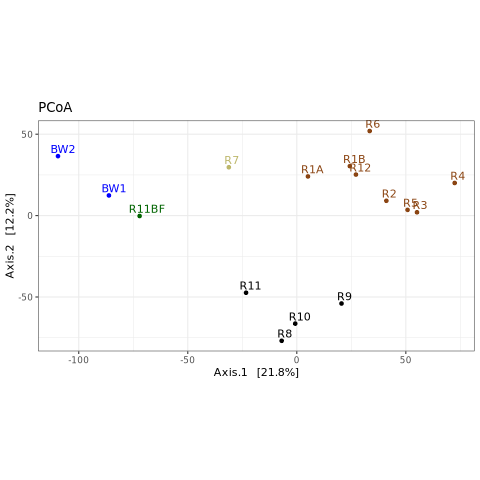

In [43]:
%%R

#Phyloseq funciona otorgándole un objeto que se forma con las tablas
#hechas previamente. Así que hay que ponerlas de la siguiente forma:
vst_count_phy <- otu_table(vst_trans_count_tab, taxa_are_rows=T)
sample_info_tab_phy <- sample_data(sample_info_tab)
vst_physeq <- phyloseq(vst_count_phy, sample_info_tab_phy)

# Generamos el PCoA de la siguiente forma.
vst_pcoa <- ordinate(vst_physeq, method="MDS", distance="euclidean")
eigen_vals <- vst_pcoa$values$Eigenvalues #escalamiento de ejes

plot_ordination(vst_physeq, vst_pcoa, color = "char") +
  geom_point(size = 1) +
  labs(col = "type") +
  geom_text(aes(label = rownames(sample_info_tab)), hjust = 0.3, vjust = -0.4) +
  coord_fixed(ratio = sqrt(eigen_vals[2] / eigen_vals[1])) +
  ggtitle("PCoA") +
  scale_color_manual(values = unique(sample_info_tab$color[order(sample_info_tab$char)])) +
  theme_bw() +
  theme(legend.position = "none")

### Alfa-diversity

Now, let's move on to analyze the alpha diversity of our samples. Here, we will use Shannon diversity and Chao1:

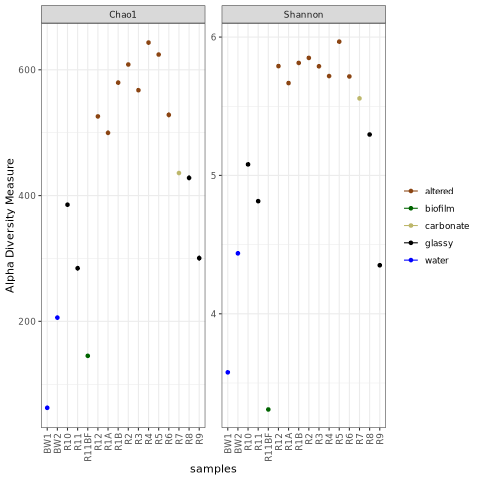

In [44]:
%%R

#first we need to create a phyloseq object using our un-transformed count table

count_tab_phy <- otu_table(count_tab, taxa_are_rows=T)
tax_tab_phy <- tax_table(tax_tab)

ASV_physeq <- phyloseq(count_tab_phy, tax_tab_phy, sample_info_tab_phy)

#and now we can call the plot_richness() function on our phyloseq object

plot_richness(ASV_physeq, color = "char", measures = c("Chao1", "Shannon")) +
  scale_color_manual(values = unique(sample_info_tab$color[order(sample_info_tab$char)])) +
  theme_bw() +
  theme(
    legend.title = element_blank(),
    axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1)
  )

We can also have another form of presentation to represent the richness.

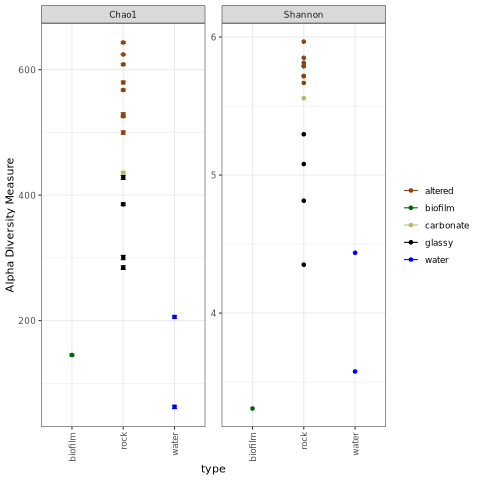

In [45]:
%%R

plot_richness(ASV_physeq, x = "type", color = "char", measures = c("Chao1", "Shannon")) +
  scale_color_manual(values = unique(sample_info_tab$color[order(sample_info_tab$char)])) +
  theme_bw() +
  theme(
    legend.title = element_blank(),
    axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1)
  )

## 5. Visualizing the taxonomy

Now, we can visualize the taxonomic groups we have obtained. To do this, we need to prepare the taxonomic groups we have.

We will create a table that sums the phyla:

In [46]:
%%R

phyla_counts_tab <- otu_table(tax_glom(ASV_physeq, taxrank="phylum"))

A vector that can give us the row names:

In [47]:
%%R

phyla_tax_vec <- as.vector(tax_table(tax_glom(ASV_physeq, taxrank="phylum"))[,"phylum"])
rownames(phyla_counts_tab) <- as.vector(phyla_tax_vec)

It’s time to sort and take the unclassified ones into account:

In [48]:
%%R

unclassified_tax_counts <- colSums(count_tab) - colSums(phyla_counts_tab)

Now we need to add this to the table:

In [49]:
%%R

phyla_and_unidentified_counts_tab <- rbind(phyla_counts_tab, "Unclassified"=unclassified_tax_counts)

Now, let's get rid of *Proteobacteria*. No worries, we'll add it back later when we work with classes:

In [50]:
%%R

temp_major_taxa_counts_tab <- phyla_and_unidentified_counts_tab[!row.names(phyla_and_unidentified_counts_tab) %in% "Proteobacteria", ]
class_counts_tab <- otu_table(tax_glom(ASV_physeq, taxrank="class"))
head(class_counts_tab)

OTU Table:          [6 taxa and 16 samples]
                     taxa are rows
       BW1  BW2  R10 R11BF  R11  R12  R1A  R1B   R2   R3   R4   R5   R6   R7
ASV_2    0    0  724    12  682  365  281  328  328  344  399  362  213   77
ASV_3  104  841 1789  3007 1413 1854 1569 1967 1890 1666 2122 2276 1642 1152
ASV_4  294 1429 3124   598 2597 2583 2257 2751 3258 3321 3999 3445 2258 1192
ASV_13   0    0   28     2   21  374  231  331  413  215  388  249  138   21
ASV_14 136  812  437   314  342 1599 1218 1487 1724 1865 1891 1043 1278  659
ASV_30 254   42  200    63   59  222  171  237  169  139  172  196   93   27
         R8   R9
ASV_2   282  200
ASV_3  1821  810
ASV_4  2770 3338
ASV_13  245   59
ASV_14  414  886
ASV_30  468   66


In [51]:
%%R

glom_result <- tax_glom(ASV_physeq, taxrank = "class")
tax_table(glom_result)

Taxonomy Table:     [68 taxa by 7 taxonomic ranks]:
         domain     phylum              class                          order
ASV_2    "Bacteria" "Nitrospirota"      "Nitrospiria"                  NA   
ASV_3    "Bacteria" "Proteobacteria"    "Alphaproteobacteria"          NA   
ASV_4    "Bacteria" "Proteobacteria"    "Gammaproteobacteria"          NA   
ASV_13   "Bacteria" "Dadabacteria"      "Dadabacteriia"                NA   
ASV_14   "Archaea"  "Crenarchaeota"     "Nitrososphaeria"              NA   
ASV_30   "Bacteria" "Bacteroidota"      "Bacteroidia"                  NA   
ASV_38   "Bacteria" "Acidobacteriota"   "Vicinamibacteria"             NA   
ASV_49   "Bacteria" "Planctomycetota"   "Planctomycetes"               NA   
ASV_70   "Bacteria" "Calditrichota"     "Calditrichia"                 NA   
ASV_75   "Bacteria" "Acidobacteriota"   "Subgroup 21"                  NA   
ASV_82   "Bacteria" "Gemmatimonadota"   "PAUC43f marine benthic group" NA   
ASV_102  "Bacteria" "Chl

And now we will do a table per class:

In [52]:
%%R

class_tax_phy_tab <- tax_table(tax_glom(ASV_physeq, taxrank="class"))

In [53]:
%%R

phy_tmp_vec <- class_tax_phy_tab[,2]
class_tmp_vec <- class_tax_phy_tab[,3]
rows_tmp <- row.names(class_tax_phy_tab)
class_tax_tab <- data.frame("phylum"=phy_tmp_vec, "class"=class_tmp_vec, row.names = rows_tmp)

head(class_tax_tab)

               phylum               class
ASV_2    Nitrospirota         Nitrospiria
ASV_3  Proteobacteria Alphaproteobacteria
ASV_4  Proteobacteria Gammaproteobacteria
ASV_13   Dadabacteria       Dadabacteriia
ASV_14  Crenarchaeota     Nitrososphaeria
ASV_30   Bacteroidota         Bacteroidia


In [54]:
%%R

# Un vector que tenga todas las clases de Proteobacteria
proteo_classes_vec <- as.vector(class_tax_tab[class_tax_tab$phylum == "Proteobacteria", "class"])
rownames(class_counts_tab) <- as.vector(class_tax_tab$class)

In [55]:
%%R

# Conteo de clases de proteobacterias
proteo_class_counts_tab <- class_counts_tab[row.names(class_counts_tab) %in% proteo_classes_vec, ]

#Aquellas que no clasificaron, hay que ponerlas en algún lado
proteo_no_class_annotated_counts <- phyla_and_unidentified_counts_tab[row.names(phyla_and_unidentified_counts_tab) %in% "Proteobacteria", ] - colSums(proteo_class_counts_tab)

#Ahora los combinaremos
major_taxa_counts_tab <- rbind(temp_major_taxa_counts_tab, proteo_class_counts_tab, "Unresolved_Proteobacteria"=proteo_no_class_annotated_counts)

# Para ver que no hayamos perdido info, comparamos. Si es TRUE, bien
identical(colSums(major_taxa_counts_tab), colSums(count_tab))

[1] TRUE


In [56]:
%%R

# tabla de proporciones
major_taxa_proportions_tab <- apply(major_taxa_counts_tab, 2, function(x) x/sum(x)*100)

# Chequeemos la dimensión
dim(major_taxa_proportions_tab)

[1] 42 16


In [57]:
%%R

# Filtremos aquellos grupos con menos del 5%
temp_filt_major_taxa_proportions_tab <- data.frame(major_taxa_proportions_tab[apply(major_taxa_proportions_tab, 1, max) > 5, ])

# Después del filtrado
dim(temp_filt_major_taxa_proportions_tab)
head(temp_filt_major_taxa_proportions_tab)

                       BW1        BW2      R10     R11BF        R11         R12
Nitrospirota      0.000000  0.0000000 8.194680 0.1724386 10.3789378  3.43400132
Crenarchaeota     7.169215 17.2435761 4.946237 4.5121425  5.2046873 15.04374824
Bacteroidota     13.389562  0.8919091 2.297680 0.9627820  0.8978846  2.16389124
Acidobacteriota   7.907222  1.5926948 3.769100 0.1149590  2.7849642  6.39759149
Planctomycetota   1.845018  2.5483117 1.890209 2.1985918  1.6131487  4.26192492
Desulfobacterota 11.386400  0.0000000 0.000000 0.0000000  0.0913103  0.02822467
                       R1A       R1B        R2         R3          R4
Nitrospirota      3.294642  2.941176  2.639839  2.7659403  2.70710360
Crenarchaeota    14.280689 13.333931 13.875252 14.9955777 12.82990705
Bacteroidota      2.004924  2.178981  1.408451  1.1417544  1.18054142
Acidobacteriota   4.045023  4.456600  4.933602  4.3016805  3.81979782
Planctomycetota   3.364990  3.515065  2.631791  2.5247246  3.65017980
Desulfobacterota  0.

In [58]:
%%R

#Creamos el grupo “other” para no perder la cabeza
filtered_proportions <- colSums(major_taxa_proportions_tab) -
colSums(temp_filt_major_taxa_proportions_tab)
filt_major_taxa_proportions_tab <- rbind(temp_filt_major_taxa_proportions_tab, "Other"=filtered_proportions)

# copia para editar sin remordimiento
filt_major_taxa_proportions_tab_for_plot <- filt_major_taxa_proportions_tab

#columna de nombres de taxa
filt_major_taxa_proportions_tab_for_plot$Major_Taxa <- row.names(filt_major_taxa_proportions_tab_for_plot)

# transformamos la tabla para que sea más fácil de graficar
filt_major_taxa_proportions_tab_for_plot.g <- pivot_longer(filt_major_taxa_proportions_tab_for_plot, !Major_Taxa, names_to = "Sample", values_to = "Proportion") %>% data.frame()
#filt_major_taxa_proportions_tab_for_plot.g$Sample <- gsub("^X", "", filt_major_taxa_proportions_tab_for_plot.g$Sample)
head(filt_major_taxa_proportions_tab_for_plot.g)

    Major_Taxa Sample Proportion
1 Nitrospirota    BW1  0.0000000
2 Nitrospirota    BW2  0.0000000
3 Nitrospirota    R10  8.1946802
4 Nitrospirota  R11BF  0.1724386
5 Nitrospirota    R11 10.3789378
6 Nitrospirota    R12  3.4340013


In [59]:
%%R

# Añadimos columnas de color y características
sample_info_for_merge<-data.frame("Sample"=row.names(sample_info_tab), "char"=sample_info_tab$char, "color"=sample_info_tab$color, stringsAsFactors=F)

# For Rimac river:
head(sample_info_for_merge)

  Sample    char      color
1    BW1   water       blue
2    BW2   water       blue
3    R10  glassy      black
4  R11BF biofilm  darkgreen
5    R11  glassy      black
6    R12 altered chocolate4


In [60]:
%%R

#Añadimos esto a nuestra tabla hecha para graficar
filt_major_taxa_proportions_tab_for_plot.g2 <- merge(filt_major_taxa_proportions_tab_for_plot.g, sample_info_for_merge)
head(filt_major_taxa_proportions_tab_for_plot.g2)

  Sample          Major_Taxa Proportion  char color
1    BW1        Nitrospirota   0.000000 water  blue
2    BW1    Desulfobacterota  11.386400 water  blue
3    BW1 Alphaproteobacteria   5.482341 water  blue
4    BW1       Crenarchaeota   7.169215 water  blue
5    BW1    Thermoplasmatota  11.070111 water  blue
6    BW1 Gammaproteobacteria  15.498155 water  blue


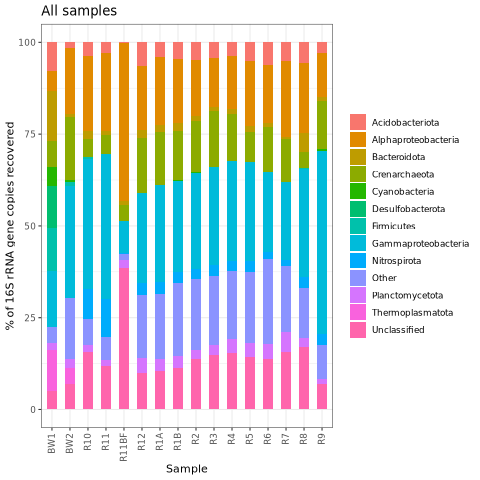

In [61]:
%%R

# Y ahora ggplot
ggplot(filt_major_taxa_proportions_tab_for_plot.g2, aes(x = Sample, y = Proportion, fill = Major_Taxa)) +
  geom_bar(width = 0.6, stat = "identity") +
  theme_bw() +
  theme(
    axis.text.x = element_text(angle = 90, vjust = 0.4, hjust = 1),
    legend.title = element_blank()
  ) +
  labs(
    x = "Sample",
    y = "% of 16S rRNA gene copies recovered",
    title = "All samples"
  )

In [62]:
%%bash

mkdir results_dada2_example
mv *.fq results_dada2_example
mv *.fq.gz results_dada2_example
mv *.fa results_dada2_example
mv *.tsv results_dada2_example
mv *.RData results_dada2_example
mv samples results_dada2_example
mv all_R_commands.R results_dada2_example
mv cutadapt_primer_trimming_stats.txt results_dada2_example

echo "All results were saved in a new directory!"

All results were saved in a new directory!


## Now trying the Rimac data:

We will now try our new knowledge with an old sample: *The microbial community in the Rimac river.*

[Read the full paper here](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0250401).

The study investigates bacterial communities in Peru's Rimac river using 16S rRNA metabarcoding. It reveals lower bacterial diversity in the Lower Rimac (Metropolitan area) compared to upstream regions. Dominant species include *Arcobacter cryaerophilus* in urban areas, a fecal contamination pathogen linked to antibiotic resistance, and *Flavobacterium succinicans* in the Upper Rimac. Functional predictions highlight bacterial motility and quorum sensing. Additional analyses detected insecticides and herbicides in upstream sub-basins, emphasizing the need for next-generation sequencing in pathogen surveillance and environmental monitoring.

<div style="text-align: center;">
  <img src="https://journals.plos.org/plosone/article/figure/image?size=large&id=10.1371/journal.pone.0250401.g001" alt="Figure from the paper" width="50%">
</div>

In [63]:
%%bash
tar -xzvf rimac_16S_sampled_fastqs.tar.gz
ls sampled_fastqs
mv sampled_fastqs/* .

sampled_fastqs/
sampled_fastqs/03_Tamboraque_Parac_Upper_Rimac_sub_R2.fq
sampled_fastqs/10_Nuevo_Lower_Rimac_sub_R1.fq
sampled_fastqs/06_Santa_Eulalia_Santa_Eulalia_sub_R1.fq
sampled_fastqs/05_Chacahuaro_Parac_Santa_Eulalia_sub_R2.fq
sampled_fastqs/06_Santa_Eulalia_Santa_Eulalia_sub_R2.fq
sampled_fastqs/03_Tamboraque_Parac_Upper_Rimac_sub_R1.fq
sampled_fastqs/21_Libertadores_Lower_Rimac_sub_R1.fq
sampled_fastqs/09_Libertadores_Lower_Rimac_sub_R1.fq
sampled_fastqs/17_Playa_La_Herradura_Coastal_region_sub_R2.fq
sampled_fastqs/05_Chacahuaro_Parac_Santa_Eulalia_sub_R1.fq
sampled_fastqs/14_Chicla_Upper_Rimac_sub_R2.fq
sampled_fastqs/24_Gambetta_Lower_Rimac_sub_R2.fq
sampled_fastqs/15_San_Mateo_Upper_Rimac_sub_R1.fq
sampled_fastqs/16_Tamboraque_Parac_Upper_Rimac_sub_R1.fq
sampled_fastqs/07_Chaclacayo_Santa_Eulalia_Jicamarca_sub_R1.fq
sampled_fastqs/09_Libertadores_Lower_Rimac_sub_R2.fq
sampled_fastqs/17_Huanchor_Parac_Santa_Eulalia_sub_R2.fq
sampled_fastqs/08_Huachipa_Santa_Eulalia_Jicamarca

In [64]:
!ls *_R1.fq | sed 's/_sub_R1\.fq$//' > samples

In [65]:
%%R
getwd()

[1] "/home/marlen/gitrepos/dada2_msm-course-2024"


In [66]:
%%R
library(dada2)
packageVersion("dada2")

[1] ‘1.30.0’


In [67]:
%%R
samples <- scan("samples", what="character")
list.files()

 [1] "03_Tamboraque_Parac_Upper_Rimac_sub_R1.fq"      
 [2] "03_Tamboraque_Parac_Upper_Rimac_sub_R2.fq"      
 [3] "04_Huanchor_Parac_Santa_Eulalia_sub_R1.fq"      
 [4] "04_Huanchor_Parac_Santa_Eulalia_sub_R2.fq"      
 [5] "05_Chacahuaro_Parac_Santa_Eulalia_sub_R1.fq"    
 [6] "05_Chacahuaro_Parac_Santa_Eulalia_sub_R2.fq"    
 [7] "06_Santa_Eulalia_Santa_Eulalia_sub_R1.fq"       
 [8] "06_Santa_Eulalia_Santa_Eulalia_sub_R2.fq"       
 [9] "07_Chaclacayo_Santa_Eulalia_Jicamarca_sub_R1.fq"
[10] "07_Chaclacayo_Santa_Eulalia_Jicamarca_sub_R2.fq"
[11] "08_Huachipa_Santa_Eulalia_Jicamarca_sub_R1.fq"  
[12] "08_Huachipa_Santa_Eulalia_Jicamarca_sub_R2.fq"  
[13] "09_Libertadores_Lower_Rimac_sub_R1.fq"          
[14] "09_Libertadores_Lower_Rimac_sub_R2.fq"          
[15] "10_Nuevo_Lower_Rimac_sub_R1.fq"                 
[16] "10_Nuevo_Lower_Rimac_sub_R2.fq"                 
[17] "13_Universitaria_Lower_Rimac_sub_R1.fq"         
[18] "13_Universitaria_Lower_Rimac_sub_R2.fq"         
[19] "14_C

Read 20 items


In [68]:
%%R

# We will create the variables for hosting the filtered reads

filtered_forward_reads <- paste0(samples, "_sub_R1_filtered.fq.gz")
filtered_reverse_reads <- paste0(samples, "_sub_R2_filtered.fq.gz")

In [69]:
%%R

forward_reads <- paste0(samples, "_sub_R1.fq")
reverse_reads <- paste0(samples, "_sub_R2.fq")

# We will create the variables for the trimmed reads too
trimmed_forward_reads <- paste0(samples, "_1_trimmed.fastq")
trimmed_reverse_reads <- paste0(samples, "_2_trimmed.fastq")

# Originally, the Rimac samples also contained blank samples.
# Part of the proccess requires to have those blanks as part of the workflow, as shown here:
#trimmed_forward_reads[1:20] -> trimmed_forward_reads_noblanks
#trimmed_reverse_reads[1:20] -> trimmed_reverse_reads_noblanks

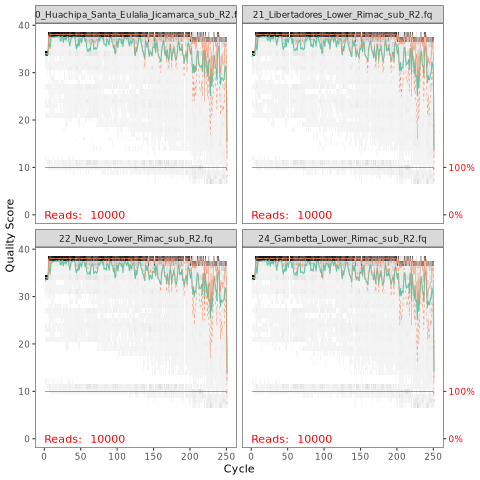

In [70]:
%%R

# Plotted using the following commands:

#plotQualityProfile(forward_reads)
#plotQualityProfile(reverse_reads)

# Since that's too messy, we can plot only 4 samples to make it easier. Like this:
plotQualityProfile(reverse_reads[17:20])

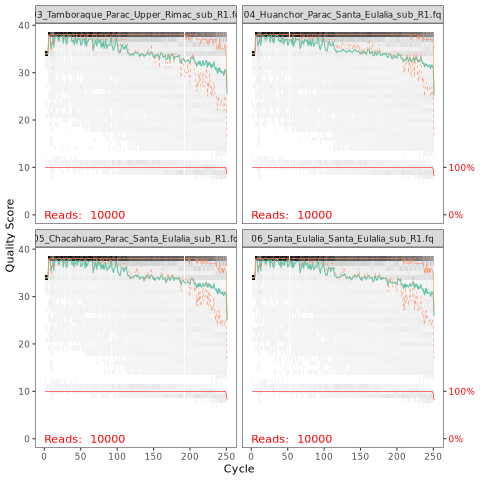

In [71]:
%%R

# Or this:
plotQualityProfile(forward_reads[1:4])

In [72]:
%%R

filtered_out <- filterAndTrim(forward_reads, filtered_forward_reads, reverse_reads, 
                              filtered_reverse_reads, maxEE=c(2,2), 
                              rm.phix=TRUE, truncLen=c(250,225))

filtered_out

#Podemos explorar nuestra data con:
class(filtered_out)
dim(filtered_out)

[1] 20  2


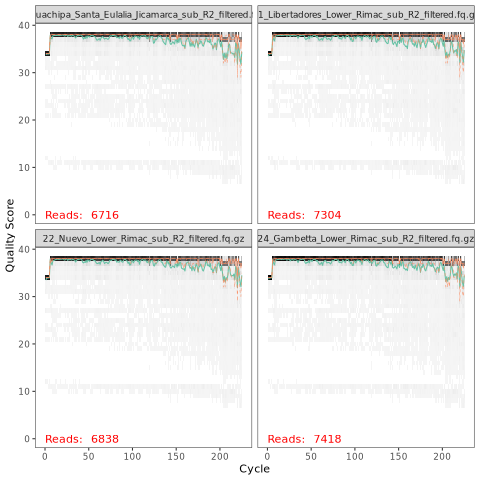

In [73]:
%%R

plotQualityProfile(filtered_reverse_reads[17:20])

In [74]:
%%R

err_forward_reads <- learnErrors(filtered_forward_reads, multithread=TRUE)
err_reverse_reads <- learnErrors(filtered_reverse_reads, multithread=TRUE)

34978750 total bases in 139915 reads from 20 samples will be used for learning the error rates.
31480875 total bases in 139915 reads from 20 samples will be used for learning the error rates.


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In scale_y_log10() :
R[write to console]:  log-10 transformation introduced infinite values.

R[write to console]: 2: 
R[write to console]: In scale_y_log10() :
R[write to console]:  log-10 transformation introduced infinite values.



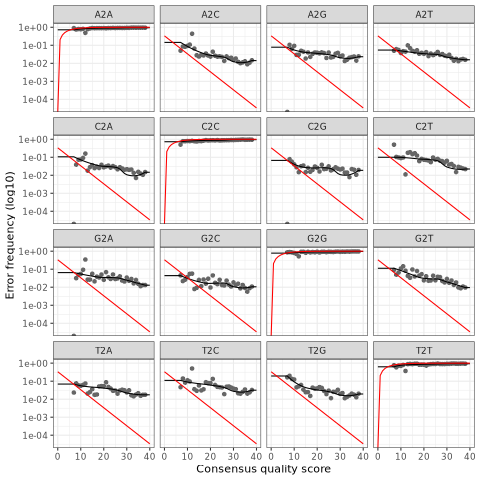

In [75]:
%%R

plotErrors(err_forward_reads, nominalQ=TRUE)

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In scale_y_log10() :
R[write to console]:  log-10 transformation introduced infinite values.



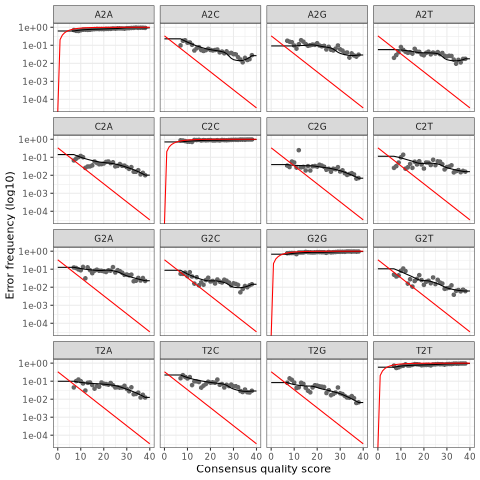

In [76]:
%%R

plotErrors(err_reverse_reads, nominalQ=TRUE)

In [77]:
%%R

derep_forward <- derepFastq(filtered_forward_reads, verbose=TRUE)
names(derep_forward) <- samples

derep_reverse <- derepFastq(filtered_reverse_reads, verbose=TRUE)
names(derep_reverse) <- samples

Dereplicating sequence entries in Fastq file: 03_Tamboraque_Parac_Upper_Rimac_sub_R1_filtered.fq.gz
Encountered 5557 unique sequences from 6890 total sequences read.
Dereplicating sequence entries in Fastq file: 04_Huanchor_Parac_Santa_Eulalia_sub_R1_filtered.fq.gz
Encountered 5403 unique sequences from 7238 total sequences read.
Dereplicating sequence entries in Fastq file: 05_Chacahuaro_Parac_Santa_Eulalia_sub_R1_filtered.fq.gz
Encountered 5715 unique sequences from 7055 total sequences read.
Dereplicating sequence entries in Fastq file: 06_Santa_Eulalia_Santa_Eulalia_sub_R1_filtered.fq.gz
Encountered 6037 unique sequences from 6913 total sequences read.
Dereplicating sequence entries in Fastq file: 07_Chaclacayo_Santa_Eulalia_Jicamarca_sub_R1_filtered.fq.gz
Encountered 5244 unique sequences from 6531 total sequences read.
Dereplicating sequence entries in Fastq file: 08_Huachipa_Santa_Eulalia_Jicamarca_sub_R1_filtered.fq.gz
Encountered 5247 unique sequences from 6420 total sequences

In [78]:
%%R

dada_forward <- dada(derep_forward, err=err_forward_reads, pool="pseudo", multithread=T)
dada_reverse <- dada(derep_reverse, err=err_reverse_reads, pool="pseudo", multithread=T)

Sample 1 - 6890 reads in 5557 unique sequences.
Sample 2 - 7238 reads in 5403 unique sequences.
Sample 3 - 7055 reads in 5715 unique sequences.
Sample 4 - 6913 reads in 6037 unique sequences.
Sample 5 - 6531 reads in 5244 unique sequences.
Sample 6 - 6420 reads in 5247 unique sequences.
Sample 7 - 7443 reads in 4746 unique sequences.
Sample 8 - 6953 reads in 4885 unique sequences.
Sample 9 - 6755 reads in 4753 unique sequences.
Sample 10 - 6989 reads in 5283 unique sequences.
Sample 11 - 7078 reads in 5269 unique sequences.
Sample 12 - 7132 reads in 5612 unique sequences.
Sample 13 - 7042 reads in 5366 unique sequences.
Sample 14 - 7519 reads in 4923 unique sequences.
Sample 15 - 6820 reads in 5962 unique sequences.
Sample 16 - 6861 reads in 5449 unique sequences.
Sample 17 - 6716 reads in 5564 unique sequences.
Sample 18 - 7304 reads in 4766 unique sequences.
Sample 19 - 6838 reads in 4803 unique sequences.
Sample 20 - 7418 reads in 4941 unique sequences.

   selfConsist step 2Sample 

In [121]:
%%R

merged_amplicons <- mergePairs(dada_forward, derep_forward, dada_reverse, derep_reverse, trimOverhang=TRUE, minOverlap = 15)

In [122]:
%%R

seqtab <- makeSequenceTable(merged_amplicons)

class(seqtab) # matrix
dim(seqtab) # 20 2521

[1]   20 2033


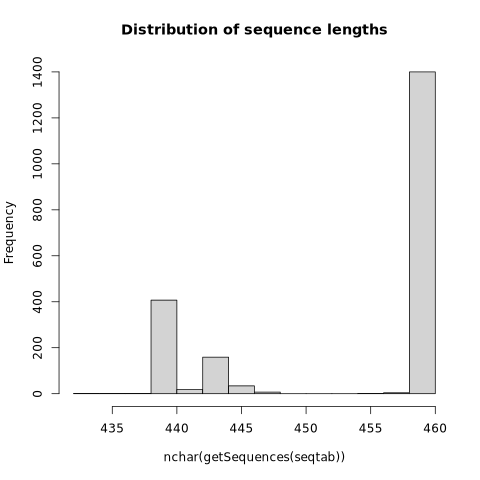

In [123]:
%%R

#It is possible to make a table and histogram of the data
table(nchar(getSequences(seqtab)))
hist(nchar(getSequences(seqtab)), main="Distribution of sequence lengths")

In [124]:
%%R

seqtab.nochim <- removeBimeraDenovo(seqtab, verbose=T)

#Y podemos revisar cuánto hemos perdido con esto también. La idea es que tengamos un decimal cercano al 1:
sum(seqtab.nochim)/sum(seqtab)

[1] 0.7976203


Identified 960 bimeras out of 2033 input sequences.


In [125]:
%%R

getN <- function(x) sum(getUniques(x))
summary_tab <- data.frame(row.names=samples,
dada2_input=filtered_out[,1], filtered=filtered_out[,2],
dada_f=sapply(dada_forward, getN), dada_r=sapply(dada_reverse, getN),
merged=sapply(merged_amplicons, getN), nonchim=rowSums(seqtab.nochim),
final_perc_reads_retained=round(rowSums(seqtab.nochim)/filtered_out[,1]
*100, 1))

summary_tab

write.table(summary_tab, "read-count-tracking.tsv", quote=FALSE, sep="\t", col.names=NA)

In [126]:
%%R
taxa70 <- assignTaxonomy(seqtab.nochim, "silva_nr_v138_train_set.fa.gz", minBoot = 70, tryRC=T, multithread = T, verbose = T)
tax_info <- taxa70
save(taxa70, file='taxa70.RData')
save(tax_info, file='tax-info.RData')

Finished processing reference fasta.

In [127]:
%%R

load("tax-info.RData")
load("taxa70.RData")

In [128]:
#%%R

#chunk.size <- 1000
#taxa_sp_nov<- do.call(rbind,
#                      lapply(split(c(1:ncol(seqtab.nochim_cut)),
#                                   sort(c(1:ncol(seqtab.nochim_cut))%%ceiling(ncol(seqtab.nochim_cut)/chunk.size))),
#                             function(x){
#                               return(assignSpecies(getSequences(seqtab.nochim_cut)[x],
#                                                    "../silva_species_assignment_v138.fa.gz", tryRC = T))
#                             }))
#save(taxa_sp_nov, file='taxa_sp_nov.RData')

In [129]:
%%R

#Each ASV sequence wil serve as a header
asv_seqs <- colnames(seqtab.nochim)
head(asv_seqs)
#Then, we will transform the ASV header to the proper name, p.e. ASV_1
asv_headers <- vector(dim(seqtab.nochim)[2], mode="character")
for (i in 1:dim(seqtab.nochim)[2]) {
  asv_headers[i] <- paste(">ASV", i, sep="_")
}
head(asv_headers)

asv_tax <- taxa70
row.names(asv_tax) <- sub(">", "", asv_headers)
write.table(asv_tax, "ASVs_taxonomy.nov.tsv", sep="\t", quote=F, col.names=NA)

# making and writing out a fasta of our final ASV seqs:
asv_fasta <- c(rbind(asv_headers, asv_seqs))
write(asv_fasta, "ASVs.nov.fa")


#count table
asv_tab <- t(seqtab.nochim)
row.names(asv_tab) <- sub(">", "", asv_headers)
write.table(asv_tab, "ASVs_counts.nov.tsv", sep="\t", quote=F, col.names=NA)

save(seqtab.nochim, file = 'seqtab.nochim.RData')
colnames(asv_tab)

 [1] "03_Tamboraque_Parac_Upper_Rimac"      
 [2] "04_Huanchor_Parac_Santa_Eulalia"      
 [3] "05_Chacahuaro_Parac_Santa_Eulalia"    
 [4] "06_Santa_Eulalia_Santa_Eulalia"       
 [5] "07_Chaclacayo_Santa_Eulalia_Jicamarca"
 [6] "08_Huachipa_Santa_Eulalia_Jicamarca"  
 [7] "09_Libertadores_Lower_Rimac"          
 [8] "10_Nuevo_Lower_Rimac"                 
 [9] "13_Universitaria_Lower_Rimac"         
[10] "14_Chicla_Upper_Rimac"                
[11] "15_San_Mateo_Upper_Rimac"             
[12] "16_Tamboraque_Parac_Upper_Rimac"      
[13] "17_Huanchor_Parac_Santa_Eulalia"      
[14] "17_Playa_La_Herradura_Coastal_region" 
[15] "18_Santa_Eulalia_Santa_Eulalia"       
[16] "19_Chaclacayo_Santa_Eulalia_Jicamarca"
[17] "20_Huachipa_Santa_Eulalia_Jicamarca"  
[18] "21_Libertadores_Lower_Rimac"          
[19] "22_Nuevo_Lower_Rimac"                 
[20] "24_Gambetta_Lower_Rimac"              


In [130]:
%%R
asv_fasta_no_contam <- asv_fasta
asv_tab_no_contam <- asv_tab
asv_tax_no_contam <- asv_tax

write(asv_fasta_no_contam, "ASVs-no-contam.fa")
write.table(asv_tab_no_contam, "ASVs_counts-no-contam.tsv", sep="\t", quote=F, col.names=NA)
write.table(asv_tax_no_contam, "ASVs_taxonomy-no-contam.tsv", sep="\t", quote=F, col.names=NA)

In [131]:
%%R
head(asv_tab_no_contam)

      03_Tamboraque_Parac_Upper_Rimac 04_Huanchor_Parac_Santa_Eulalia
ASV_1                               2                               0
ASV_2                               0                               0
ASV_3                               3                               0
ASV_4                               2                               1
ASV_5                               3                               2
ASV_6                               6                               0
      05_Chacahuaro_Parac_Santa_Eulalia 06_Santa_Eulalia_Santa_Eulalia
ASV_1                                 2                              1
ASV_2                                 0                              3
ASV_3                                 2                              1
ASV_4                                 0                              2
ASV_5                                 0                              1
ASV_6                                 2                              0
      07_Chac

In [132]:
%%R
head(asv_tax_no_contam)

      Kingdom    Phylum             Class             Order              
ASV_1 "Bacteria" "Campilobacterota" "Campylobacteria" "Campylobacterales"
ASV_2 "Bacteria" "Campilobacterota" "Campylobacteria" "Campylobacterales"
ASV_3 "Bacteria" "Campilobacterota" "Campylobacteria" "Campylobacterales"
ASV_4 "Bacteria" "Campilobacterota" "Campylobacteria" "Campylobacterales"
ASV_5 "Bacteria" "Campilobacterota" "Campylobacteria" "Campylobacterales"
ASV_6 "Bacteria" "Campilobacterota" "Campylobacteria" "Campylobacterales"
      Family            Genus       
ASV_1 "Arcobacteraceae" "Arcobacter"
ASV_2 "Arcobacteraceae" "Arcobacter"
ASV_3 "Arcobacteraceae" "Arcobacter"
ASV_4 "Arcobacteraceae" "Arcobacter"
ASV_5 "Arcobacteraceae" "Arcobacter"
ASV_6 "Arcobacteraceae" "Arcobacter"


In [133]:
%%R

count_tab <- read.table("ASVs_counts-no-contam.tsv", header=T, row.names=1, check.names=F, sep="\t")
colnames(count_tab)

 [1] "03_Tamboraque_Parac_Upper_Rimac"      
 [2] "04_Huanchor_Parac_Santa_Eulalia"      
 [3] "05_Chacahuaro_Parac_Santa_Eulalia"    
 [4] "06_Santa_Eulalia_Santa_Eulalia"       
 [5] "07_Chaclacayo_Santa_Eulalia_Jicamarca"
 [6] "08_Huachipa_Santa_Eulalia_Jicamarca"  
 [7] "09_Libertadores_Lower_Rimac"          
 [8] "10_Nuevo_Lower_Rimac"                 
 [9] "13_Universitaria_Lower_Rimac"         
[10] "14_Chicla_Upper_Rimac"                
[11] "15_San_Mateo_Upper_Rimac"             
[12] "16_Tamboraque_Parac_Upper_Rimac"      
[13] "17_Huanchor_Parac_Santa_Eulalia"      
[14] "17_Playa_La_Herradura_Coastal_region" 
[15] "18_Santa_Eulalia_Santa_Eulalia"       
[16] "19_Chaclacayo_Santa_Eulalia_Jicamarca"
[17] "20_Huachipa_Santa_Eulalia_Jicamarca"  
[18] "21_Libertadores_Lower_Rimac"          
[19] "22_Nuevo_Lower_Rimac"                 
[20] "24_Gambetta_Lower_Rimac"              


In [134]:
%%R

sample_info_tab <- read.csv("metadata.csv", header=T, row.names=1, check.names=F)
sample_info_tab

                                                          region    elevat
03_Tamboraque_Parac_Upper_Rimac             02.Parac_Upper_Rimac 3023.4084
04_Huanchor_Parac_Santa_Eulalia           03.Santa_Eulalia_Parac 2868.3452
05_Chacahuaro_Parac_Santa_Eulalia         03.Santa_Eulalia_Parac 2526.4741
06_Santa_Eulalia_Santa_Eulalia                  04.Santa_Eulalia  948.4070
07_Chaclacayo_Santa_Eulalia_Jicamarca 05.Jicamarca_Santa_Eulalia  656.6750
08_Huachipa_Santa_Eulalia_Jicamarca   05.Jicamarca_Santa_Eulalia  395.5056
09_Libertadores_Lower_Rimac                       06.Lower_Rimac  213.0000
10_Nuevo_Lower_Rimac                              06.Lower_Rimac  200.0000
13_Universitaria_Lower_Rimac                      06.Lower_Rimac   69.0000
14_Chicla_Upper_Rimac                             01.Upper_Rimac 3440.8064
15_San_Mateo_Upper_Rimac                    02.Parac_Upper_Rimac 3421.6155
16_Tamboraque_Parac_Upper_Rimac             02.Parac_Upper_Rimac 3023.4084
17_Huanchor_Parac_Santa_E

In [135]:
%%R

count_tab <- count_tab[rowSums(count_tab) > 0, ]
count_tab <- count_tab + 1
sample_info_tab$region <- as.factor(sample_info_tab$region)

deseq_counts <- DESeqDataSetFromMatrix(count_tab, colData = sample_info_tab, design = ~region)
deseq_counts_vst <- varianceStabilizingTransformation(deseq_counts)

vst_trans_count_tab <- assay(deseq_counts_vst)
euc_dist <- dist(t(vst_trans_count_tab))

converting counts to integer mode
-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.


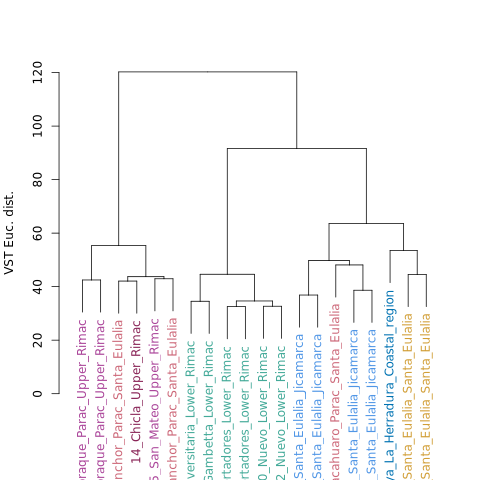

In [136]:
%%R

euc_clust <- hclust(euc_dist, method="ward.D2")

#Se puede plotear de este modo
plot(euc_clust)

#Como también podemos transformarlo en un dendograma, que es más simple de editar
euc_dend <- as.dendrogram(euc_clust, hang=0.1)
dend_cols <- as.character(sample_info_tab$color[order.dendrogram(euc_dend)])
labels_colors(euc_dend) <- dend_cols

plot(euc_dend, ylab="VST Euc. dist.")

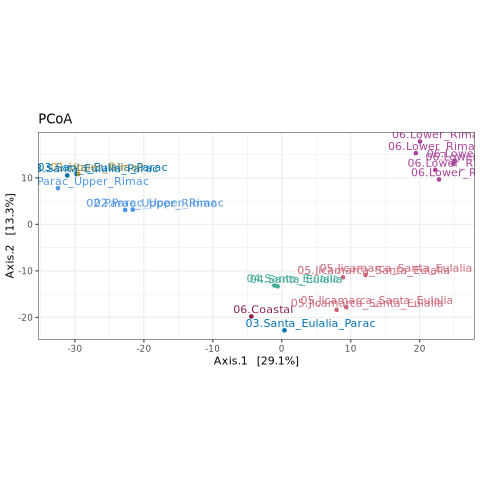

In [137]:
%%R

#Phyloseq funciona otorgándole un objeto que se forma con las tablas
#hechas previamente. Así que hay que ponerlas de la siguiente forma:
vst_count_phy <- otu_table(vst_trans_count_tab, taxa_are_rows=T)
sample_info_tab_phy <- sample_data(sample_info_tab)
vst_physeq <- phyloseq(vst_count_phy, sample_info_tab_phy)

# Generamos el PCoA de la siguiente forma.
vst_pcoa <- ordinate(vst_physeq, method="MDS", distance="euclidean")
eigen_vals <- vst_pcoa$values$Eigenvalues

plot_ordination(vst_physeq, vst_pcoa, color = "color") +
  geom_point(size = 1) +
  labs(col = "region") + #labs(col = "type") +
  geom_text(aes(label = sample_info_tab$region), hjust = 0.3, vjust = -0.4) +
  coord_fixed(ratio = sqrt(eigen_vals[2] / eigen_vals[1])) +
  ggtitle("PCoA") +
  scale_color_manual(values = unique(sample_info_tab$color[order(sample_info_tab$region)])) +
  theme_bw() +
  theme(legend.position = "none")

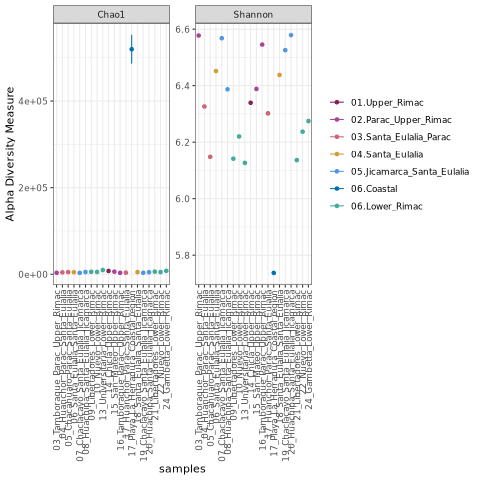

In [138]:
%%R

#first we need to create a phyloseq object using our un-transformed count table

count_tab_phy <- otu_table(count_tab, taxa_are_rows=T)
tax_tab_phy <- tax_table(tax_tab)

ASV_physeq <- phyloseq(count_tab_phy, tax_tab_phy, sample_info_tab_phy)

#and now we can call the plot_richness() function on our phyloseq object

plot_richness(ASV_physeq, color = "region", measures = c("Chao1", "Shannon")) +
  scale_color_manual(values = unique(sample_info_tab$color[order(sample_info_tab$region)])) +
  theme_bw() +
  theme(
    legend.title = element_blank(),
    axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1)
  )

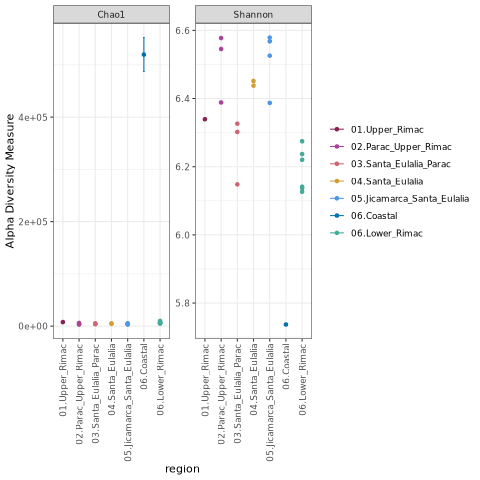

In [139]:
%%R

plot_richness(ASV_physeq, x = "region", color = "region", measures = c("Chao1", "Shannon")) +
  scale_color_manual(values = unique(sample_info_tab$color[order(sample_info_tab$region)])) +
  theme_bw() +
  theme(
    legend.title = element_blank(),
    axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1)
  )

In [140]:
%%R

phyla_counts_tab <- otu_table(tax_glom(ASV_physeq, taxrank="phylum"))

In [141]:
%%R

phyla_tax_vec <- as.vector(tax_table(tax_glom(ASV_physeq, taxrank="phylum"))[,"phylum"])
rownames(phyla_counts_tab) <- as.vector(phyla_tax_vec)

In [142]:
%%R

unclassified_tax_counts <- colSums(count_tab) - colSums(phyla_counts_tab)

In [143]:
%%R

phyla_and_unidentified_counts_tab <- rbind(phyla_counts_tab, "Unclassified"=unclassified_tax_counts)

In [144]:
%%R

temp_major_taxa_counts_tab <- phyla_and_unidentified_counts_tab[!row.names(phyla_and_unidentified_counts_tab) %in% "Proteobacteria", ]
class_counts_tab <- otu_table(tax_glom(ASV_physeq, taxrank="class"))
head(class_counts_tab)

OTU Table:          [6 taxa and 20 samples]
                     taxa are rows
       03_Tamboraque_Parac_Upper_Rimac 04_Huanchor_Parac_Santa_Eulalia
ASV_2                               39                              31
ASV_3                              416                             427
ASV_4                              555                             587
ASV_13                              25                              42
ASV_14                             242                             381
ASV_30                              55                              45
       05_Chacahuaro_Parac_Santa_Eulalia 06_Santa_Eulalia_Santa_Eulalia
ASV_2                                141                             46
ASV_3                                418                            333
ASV_4                                626                            491
ASV_13                                34                             38
ASV_14                               235                        

In [145]:
%%R

glom_result <- tax_glom(ASV_physeq, taxrank = "class")
tax_table(glom_result)

Taxonomy Table:     [46 taxa by 7 taxonomic ranks]:
        domain     phylum              class                          order
ASV_2   "Bacteria" "Nitrospirota"      "Nitrospiria"                  NA   
ASV_3   "Bacteria" "Proteobacteria"    "Alphaproteobacteria"          NA   
ASV_4   "Bacteria" "Proteobacteria"    "Gammaproteobacteria"          NA   
ASV_13  "Bacteria" "Dadabacteria"      "Dadabacteriia"                NA   
ASV_14  "Archaea"  "Crenarchaeota"     "Nitrososphaeria"              NA   
ASV_30  "Bacteria" "Bacteroidota"      "Bacteroidia"                  NA   
ASV_38  "Bacteria" "Acidobacteriota"   "Vicinamibacteria"             NA   
ASV_49  "Bacteria" "Planctomycetota"   "Planctomycetes"               NA   
ASV_70  "Bacteria" "Calditrichota"     "Calditrichia"                 NA   
ASV_75  "Bacteria" "Acidobacteriota"   "Subgroup 21"                  NA   
ASV_82  "Bacteria" "Gemmatimonadota"   "PAUC43f marine benthic group" NA   
ASV_102 "Bacteria" "Chloroflexi"    

In [146]:
%%R

class_tax_phy_tab <- tax_table(tax_glom(ASV_physeq, taxrank="class"))

In [147]:
%%R

phy_tmp_vec <- class_tax_phy_tab[,2]
class_tmp_vec <- class_tax_phy_tab[,3]
rows_tmp <- row.names(class_tax_phy_tab)

class_tax_tab <- data.frame("phylum"=phy_tmp_vec, "class"=class_tmp_vec, row.names = rows_tmp)
head(class_tax_tab)

               phylum               class
ASV_2    Nitrospirota         Nitrospiria
ASV_3  Proteobacteria Alphaproteobacteria
ASV_4  Proteobacteria Gammaproteobacteria
ASV_13   Dadabacteria       Dadabacteriia
ASV_14  Crenarchaeota     Nitrososphaeria
ASV_30   Bacteroidota         Bacteroidia


In [148]:
%%R

rownames(class_counts_tab) <- as.vector(class_tax_tab$class)
head(class_counts_tab)

OTU Table:          [6 taxa and 20 samples]
                     taxa are rows
                    03_Tamboraque_Parac_Upper_Rimac
Nitrospiria                                      39
Alphaproteobacteria                             416
Gammaproteobacteria                             555
Dadabacteriia                                    25
Nitrososphaeria                                 242
Bacteroidia                                      55
                    04_Huanchor_Parac_Santa_Eulalia
Nitrospiria                                      31
Alphaproteobacteria                             427
Gammaproteobacteria                             587
Dadabacteriia                                    42
Nitrososphaeria                                 381
Bacteroidia                                      45
                    05_Chacahuaro_Parac_Santa_Eulalia
Nitrospiria                                       141
Alphaproteobacteria                               418
Gammaproteobacteria            

In [149]:
%%R

major_taxa_counts_tab <- class_counts_tab
major_taxa_proportions_tab <- apply(major_taxa_counts_tab, 2, function(x) x/sum(x)*100)

# Chequeemos la dimensión
dim(major_taxa_proportions_tab)

[1] 46 20


In [150]:
%%R

# Filtremos aquellos grupos con menos del 5%
temp_filt_major_taxa_proportions_tab <- data.frame(major_taxa_proportions_tab[apply(major_taxa_proportions_tab, 1, max) > 5, ])

# Después del filtrado
dim(temp_filt_major_taxa_proportions_tab)
head(temp_filt_major_taxa_proportions_tab)

                    X03_Tamboraque_Parac_Upper_Rimac
Nitrospiria                                 2.018634
Alphaproteobacteria                        21.532091
Gammaproteobacteria                        28.726708
Nitrososphaeria                            12.525880
Vicinamibacteria                            2.691511
Planctomycetes                              4.037267
                    X04_Huanchor_Parac_Santa_Eulalia
Nitrospiria                                 1.454034
Alphaproteobacteria                        20.028143
Gammaproteobacteria                        27.532833
Nitrososphaeria                            17.870544
Vicinamibacteria                            3.048780
Planctomycetes                              2.439024
                    X05_Chacahuaro_Parac_Santa_Eulalia
Nitrospiria                                   7.018417
Alphaproteobacteria                          20.806371
Gammaproteobacteria                          31.159781
Nitrososphaeria                       

In [151]:
%%R

#Creamos el grupo “other” para no perder la cabeza
filtered_proportions <- colSums(major_taxa_proportions_tab) -
colSums(temp_filt_major_taxa_proportions_tab)
filt_major_taxa_proportions_tab <- rbind(temp_filt_major_taxa_proportions_tab, "Other"=filtered_proportions)

# copia para editar sin remordimiento
filt_major_taxa_proportions_tab_for_plot <- filt_major_taxa_proportions_tab

#columna de nombres de taxa
filt_major_taxa_proportions_tab_for_plot$Major_Taxa <- row.names(filt_major_taxa_proportions_tab_for_plot)

# transformamos la tabla para que sea más fácil de graficar
filt_major_taxa_proportions_tab_for_plot.g <- pivot_longer(filt_major_taxa_proportions_tab_for_plot, !Major_Taxa, names_to = "Sample", values_to = "Proportion") %>% data.frame()
filt_major_taxa_proportions_tab_for_plot.g$Sample <- gsub("^X", "", filt_major_taxa_proportions_tab_for_plot.g$Sample)
head(filt_major_taxa_proportions_tab_for_plot.g)

   Major_Taxa                                Sample Proportion
1 Nitrospiria       03_Tamboraque_Parac_Upper_Rimac   2.018634
2 Nitrospiria       04_Huanchor_Parac_Santa_Eulalia   1.454034
3 Nitrospiria     05_Chacahuaro_Parac_Santa_Eulalia   7.018417
4 Nitrospiria        06_Santa_Eulalia_Santa_Eulalia   2.851829
5 Nitrospiria 07_Chaclacayo_Santa_Eulalia_Jicamarca   2.990556
6 Nitrospiria   08_Huachipa_Santa_Eulalia_Jicamarca   1.745314


In [152]:
%%R

# Añadimos columnas de color y características

sample_info_for_merge<-data.frame("Sample"=row.names(sample_info_tab), "region"=sample_info_tab$region, "color"=sample_info_tab$color, stringsAsFactors=F)
head(sample_info_for_merge)

                                 Sample                     region   color
1       03_Tamboraque_Parac_Upper_Rimac       02.Parac_Upper_Rimac #AA4499
2       04_Huanchor_Parac_Santa_Eulalia     03.Santa_Eulalia_Parac #CC6677
3     05_Chacahuaro_Parac_Santa_Eulalia     03.Santa_Eulalia_Parac #CC6677
4        06_Santa_Eulalia_Santa_Eulalia           04.Santa_Eulalia #d19e36
5 07_Chaclacayo_Santa_Eulalia_Jicamarca 05.Jicamarca_Santa_Eulalia #5096e6
6   08_Huachipa_Santa_Eulalia_Jicamarca 05.Jicamarca_Santa_Eulalia #5096e6


In [153]:
%%R

#Añadimos esto a nuestra tabla hecha para graficar
filt_major_taxa_proportions_tab_for_plot.g2 <- merge(filt_major_taxa_proportions_tab_for_plot.g, sample_info_for_merge)
head(filt_major_taxa_proportions_tab_for_plot.g2)

                           Sample          Major_Taxa Proportion
1 03_Tamboraque_Parac_Upper_Rimac         Nitrospiria   2.018634
2 03_Tamboraque_Parac_Upper_Rimac Gammaproteobacteria  28.726708
3 03_Tamboraque_Parac_Upper_Rimac    Vicinamibacteria   2.691511
4 03_Tamboraque_Parac_Upper_Rimac     Dehalococcoidia   3.623188
5 03_Tamboraque_Parac_Upper_Rimac               Other  21.480331
6 03_Tamboraque_Parac_Upper_Rimac      Planctomycetes   4.037267
                region   color
1 02.Parac_Upper_Rimac #AA4499
2 02.Parac_Upper_Rimac #AA4499
3 02.Parac_Upper_Rimac #AA4499
4 02.Parac_Upper_Rimac #AA4499
5 02.Parac_Upper_Rimac #AA4499
6 02.Parac_Upper_Rimac #AA4499


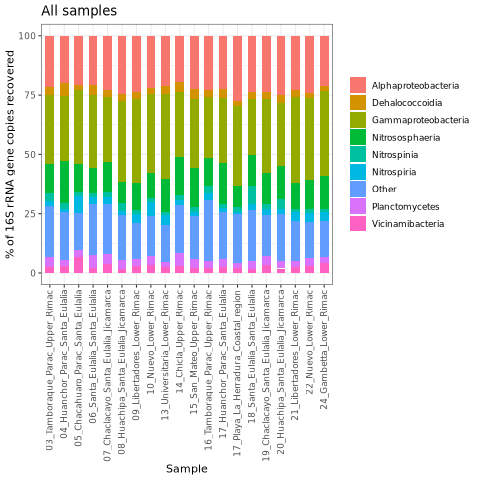

In [154]:
%%R

# Y ahora ggplot
ggplot(filt_major_taxa_proportions_tab_for_plot.g2, aes(x = Sample, y = Proportion, fill = Major_Taxa)) +
  geom_bar(width = 0.6, stat = "identity") +
  theme_bw() +
  theme(
    axis.text.x = element_text(angle = 90, vjust = 0.4, hjust = 1),
    legend.title = element_blank()
  ) +
  labs(
    x = "Sample",
    y = "% of 16S rRNA gene copies recovered",
    title = "All samples"
  )

In [155]:
%%bash

mkdir rimac_dada2_results
mv *.fq rimac_dada2_results
mv *.fq.gz rimac_dada2_results
mv *.fa rimac_dada2_results
mv *.tsv rimac_dada2_results
mv *.RData rimac_dada2_results
mv samples rimac_dada2_results

echo "All results were saved in a new directory!"

All results were saved in a new directory!
